# AI


## Bibliotecas utilizadas

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

from helper_functions import Graph, BancoDeHemocentros

## Preparando o problema

### Gerando um grafo da cidade
Vamos começar gerando o grafo da cidade em que nosso sistema vai rodar. No caso, escolhemos a cidade de São Carlos. Com a biblioteca `osmnx`, conseguimos gerar esse grafo e salvá-lo em um arquivo `.graphml`. Essa biblioteca é especializada em redes urbanas, utilizando dados geoespaciais reais para gerar um grafo de uma determinada região.

A classe `Graph` definida em `helper_functions.py` abstrai algumas funcionalidades que iremos precisar mais adiante. Para utilizar  

In [2]:
# # Nome da cidade
# cidade = "São Carlos, São Paulo, Brasil"

# # Baixa o grafo das ruas para transporte por carro (modo drive)
# G = ox.graph_from_place(cidade, network_type='drive')
# ox.save_graphml(G, filepath="sao_carlos.graphml")

Número de nós: 9042
Número de arestas: 22340


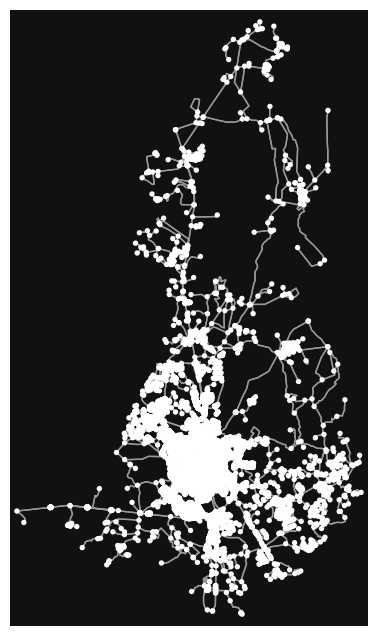

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# INSTANCIANDO A CLASSE GRAPH CRIADA
G = Graph("sao_carlos.graphml")

# Mostra informações do grafo
print(f"Número de nós: {len(G.graph.nodes)}")
print(f"Número de arestas: {len(G.graph.edges)}")

# Desenha o grafo
ox.plot_graph(G.graph)

Essa é a carinha do nosso grafo. Para visualizá-lo melhor, vamos colocar essa rede em cima do mapa real de São Carlos.

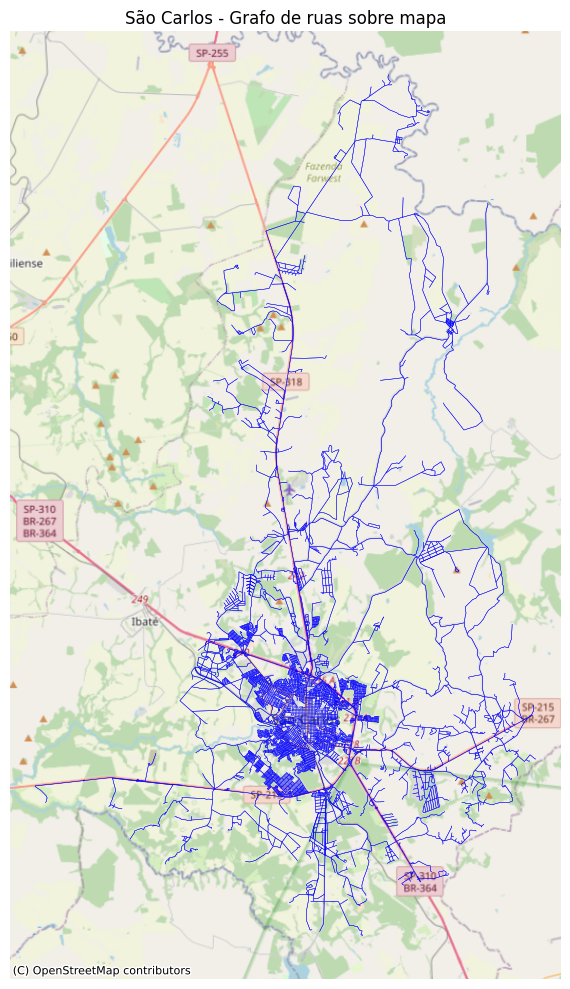

In [4]:
# Plotando as ruas de São Carlos sobre o mapa da cidade
edges = G.edges_gdf

fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.title("São Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()

plt.savefig("images/sao_carlos_mapa.png", dpi=300)

plt.show()

### Definindo os Hemocentros
Agora que já possuímos o grafo da cidade toda de São Carlos, devemos definir onde ficarão os `Hemocentros`, que são os nós de interesse do nosso problema de busca (nós finais). Para isso, vamos pegar 7 nós aleatórios, e defini-los como Hemocentros. Na classe já existe um método implementado que retorna n nós aleatórios do grafo, o método `get_random_nodes()`.

Cada nó do grafo é salvo com um ID, isto é, uma String que o identifica. Escolhendo 7 IDs aleatórios, vamos plotar sobre o mapa de São Carlos para visualizá-los.

In [5]:
# Pegando 7 nós aleatórios para representar os hemocentros
hemocentros = G.get_random_nodes(7)
print(hemocentros)

# Converte os hemocentros para GDF (somente para poder plotar)
gdf_hemocentros = G.get_gdf_nodes(hemocentros)

[1029821533, 973729057, 1091347534, 1015217457, 4272090858, 5156295549, 11770126133]


Vamos semelhantemente ao caso anterior plotar os hemocentros sobre o mapa de São Carlos, a fim de obter uma melhor visualização dos nossos dados. Os círculos vermelhos no mapa representarão a localização dos hemocentros.

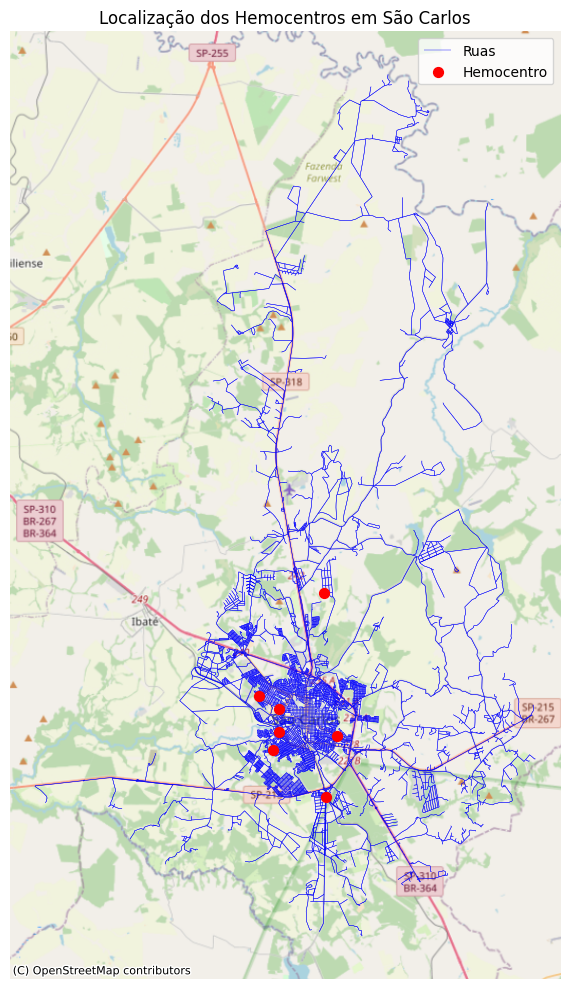

In [6]:
# Plotando o mapa
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização dos Hemocentros em São Carlos")
plt.tight_layout()

plt.savefig("images/hemocentros.png", dpi=300)

plt.show()


Precisamos ainda definir o estoque de determinado tipo sanguíneo em cada um dos hemocentros. Para isso, vamos usar uma outra classe definida em `helper_functions.py`, a classe `Hemocentros`. Essa classe abstrai todo o estoque de bolsas de sangue de todos os hemocentros da cidade de São Carlos (ou de qualquer cidade que utilize o sistema).

In [7]:
H = BancoDeHemocentros(hemocentros, G.graph)

# Exemplo, estoque de bolsas de sangue um hemocentro
H.consultar_estoque(hemocentros[0])

{'A+': 0, 'A-': 6, 'B+': 22, 'B-': 0, 'AB+': 0, 'AB-': 0, 'O+': 0, 'O-': 0}

### Localização do Usuário
Agora, que temos os hemocentros dipostos aleatoriamente, precisamos definir a localização do nó inicial, ou seja, da localização atual do usuário do sistema. Vamos também gerar uma localização aleatória para representar o ponto de partida do grafo.

In [8]:
user = G.get_random_nodes(1)
gdf_user = G.get_gdf_nodes(user)

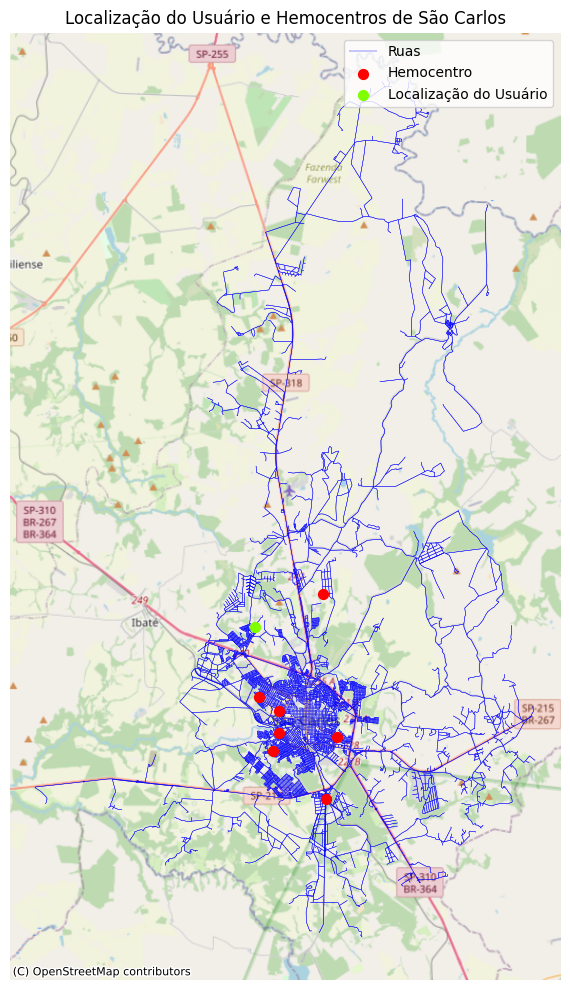

In [9]:
# Plotando o mapa com a localização aleatória
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
gdf_user.plot(ax=ax, color="chartreuse", markersize=50, zorder=3, label='Localização do Usuário')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização do Usuário e Hemocentros de São Carlos")
plt.tight_layout()

plt.savefig("images/usuario.png", dpi=300)

plt.show()

## Buscas: BFS e A*
As duas buscas implementadas para solucionar o problema são a Busca em Largura (ou Breadth-First Search) e o algoritmo A* (A-Estrela). 

Antes de implementar as buscas, o sistema deve ser capaz de identificar através do banco de dados quais hemocentros possuem os tipos sanguíneos doadores compatíveis com o do usuário. Assim, deve-se filtrar os hemocentros que não atendem às necessidades antes de realizar a busca.

In [10]:
# Definindo o tipo de sangue do usuário e filtrando os HCs válidos
blood_type = "O-"
hcs_validos = H.hemocentros_validos(blood_type)

print(hcs_validos)

[973729057, 1091347534, 4272090858, 5156295549, 11770126133]


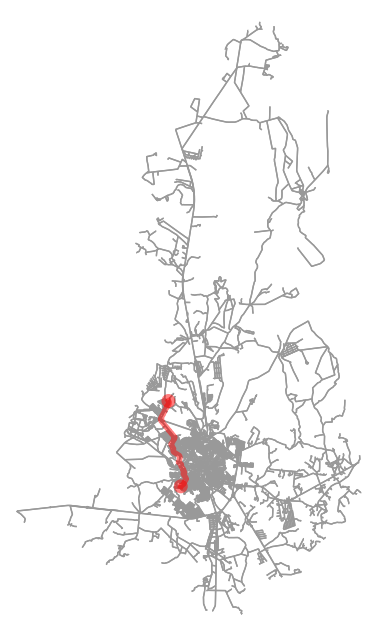

In [11]:
# Teste da função já implementada, não usar
rota = G.calcular_rota(user[0], hcs_validos[0])
G.plotar_rota(rota)

### Busca não informada: BFS (Breadth-First Search)
A Busca em Largura é a mais adequada quando o assunto é salvar vidas. Nesse problema, não estamos interessados em qualquer caminho, e sim no mais curto, ou nos mais curtos. 

No entanto, sabemos que, diferentemente de algoritmos que levam pesos e heurísticas em consideração, no BFS não somos capazes de dizer se de fato estamos percorrendo a menor distância! Isso parece contraintuitivo, mas na verdade é bem nítido.

O BFS encontrará o menor caminho em termos de arestas percorridas, mas isso não necessariamente garantirá que será a menor distância, já que não consideramos o peso das arestas. Considerações nessa estirpe não são resolvidas aqui, mas serão feitas no algoritmo A*.

In [12]:
G.graph.nodes[user[0]]

{'y': -21.958688, 'x': -47.9258959, 'street_count': 3}

Criamos o arquivo `busca_nao_informada.py`, que contém a implementação da busca em largura, a partir da função `rota_bfs` que irá:

- Receber o grafo (NetworkX)
- Receber um nó de origem
- Receber uma lista de nós de destino (vários hemocentros compatíveis)
- Retornar o primeiro caminho mais curto até algum deles

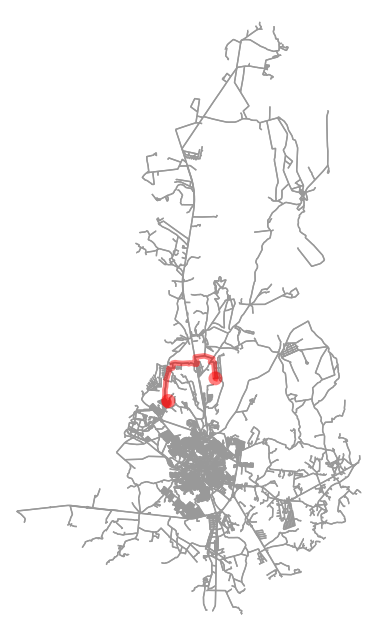

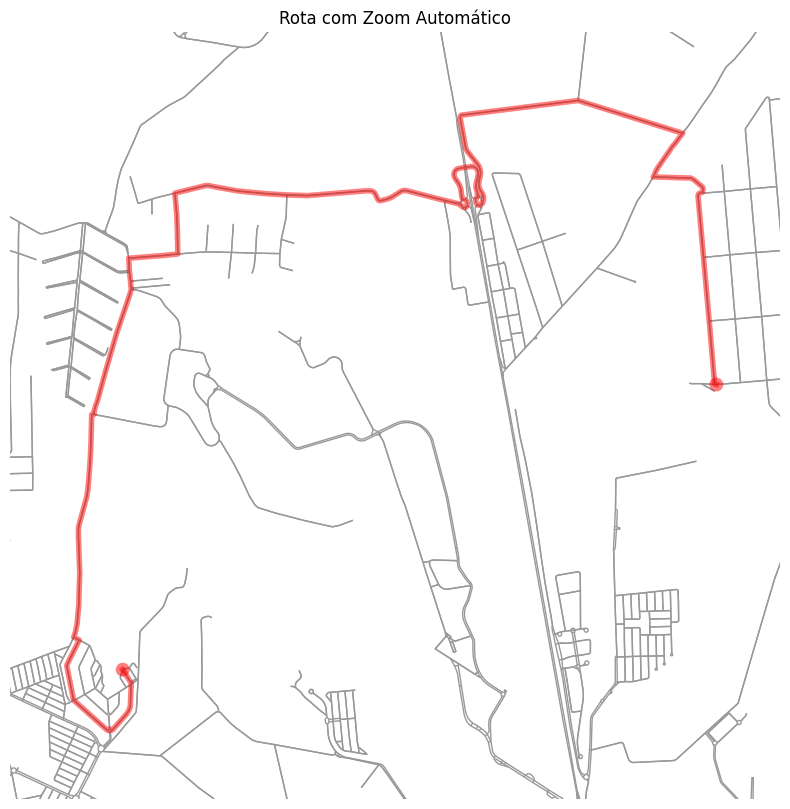

In [13]:
from busca_nao_informada import bfs

rota_bfs = bfs(G.graph, user[0], hcs_validos)

if rota_bfs:
    G.plotar_rota(rota_bfs)
    G.plotar_rota_com_zoom(rota_bfs)

else:
    print("Nenhum hemocentro acessível foi encontrado.")


A seguir estamos fazendo uma comparação entre nossa implementação da BFS e o algoritmo padrão da biblioteca networkx, que faz uma busca cuja ponderação é baseada no peso "length", que são as distâncias em metros mesmos fornecidas pelo OSM. A `rota_curta` é de fato a rota mais curta em metros, enquanto `rota_bfs` é a rota mais curta em número de arestas.

In [14]:
import networkx as nx

# Calcula rota ótima com menor distância em metros (já usa weight='length')
rota_curta = G.calcular_rota(user[0], hcs_validos[0])  # usa nx.shortest_path com peso

# Calcula rota BFS (não ponderada, menor número de nós)
from busca_nao_informada import bfs
rota_bfs = bfs(G.graph, user[0], hcs_validos)

# Mostra quantos nós foram usados em cada rota
print(f"🔴 Rota BFS: {len(rota_bfs)} nós")
print(f"🟢 Rota com menor distância (curta): {len(rota_curta)} nós")

# Compara se as rotas são iguais ou diferentes
if rota_bfs == rota_curta:
    print("✅ BFS encontrou a mesma rota da menor distância (coincidência rara).")
else:
    print("⚠️ BFS encontrou uma rota diferente da mais curta em distância — esperado!")


🔴 Rota BFS: 39 nós
🟢 Rota com menor distância (curta): 145 nós
⚠️ BFS encontrou uma rota diferente da mais curta em distância — esperado!


Olha que interessante!

O resultado acima mostra que a rota BFS, que encontra a solução que passa por menos arestas (isto é, dá menos saltos) não coincide com a solução que é de fato, mais curta, em termos de distância (em metros mesmo!). Isso era de se esperar e mostra de maneira cabal que essa busca BFS, assim como a DFS (buscas não informadas no geral) não são adequadas para esse problema, que lida com vidas humanas.

### Busca Informada: A* (A-Star)
O algoritmo A* (A-Estrela) de busca em grafos é um tipo de busca informada, no qual utiliza-se de uma heurística...